<a href="https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Cases Prediction (Regression)

# **Import Some Packages**

In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [2]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'

# **Some Utilities**


In [3]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features


In [4]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            feats = list(range(40))+ [57,75]
            pass

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [5]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [6]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

# **Train/Dev/Test**

## **Training**

In [7]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [8]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [9]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [10]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 5000,                # maximum number of epochs
    'batch_size': 250,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.0001,                 # learning rate of SGD
        'momentum': 0.9,              # momentum for SGD
        'weight_decay':1e-5
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [11]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 42)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 42)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 42)


In [12]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [13]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 316.9156)
Saving model (epoch =    2, loss = 303.3374)
Saving model (epoch =    3, loss = 285.5539)
Saving model (epoch =    4, loss = 262.6192)
Saving model (epoch =    5, loss = 232.2632)
Saving model (epoch =    6, loss = 191.7604)
Saving model (epoch =    7, loss = 141.3373)
Saving model (epoch =    8, loss = 88.1166)
Saving model (epoch =    9, loss = 44.7452)
Saving model (epoch =   10, loss = 21.4559)
Saving model (epoch =   11, loss = 13.5662)
Saving model (epoch =   12, loss = 10.1762)
Saving model (epoch =   13, loss = 7.1145)
Saving model (epoch =   14, loss = 4.7069)
Saving model (epoch =   15, loss = 3.2240)
Saving model (epoch =   16, loss = 2.4218)
Saving model (epoch =   17, loss = 2.0268)
Saving model (epoch =   18, loss = 1.8656)
Saving model (epoch =   19, loss = 1.8052)
Saving model (epoch =   20, loss = 1.7814)
Saving model (epoch =   21, loss = 1.7631)
Saving model (epoch =   22, loss = 1.7442)
Saving model (epoch =   23, loss = 

Saving model (epoch =  204, loss = 1.1125)
Saving model (epoch =  205, loss = 1.1118)
Saving model (epoch =  206, loss = 1.1111)
Saving model (epoch =  207, loss = 1.1100)
Saving model (epoch =  208, loss = 1.1091)
Saving model (epoch =  209, loss = 1.1088)
Saving model (epoch =  210, loss = 1.1083)
Saving model (epoch =  211, loss = 1.1074)
Saving model (epoch =  212, loss = 1.1065)
Saving model (epoch =  213, loss = 1.1051)
Saving model (epoch =  214, loss = 1.1045)
Saving model (epoch =  215, loss = 1.1044)
Saving model (epoch =  216, loss = 1.1038)
Saving model (epoch =  217, loss = 1.1028)
Saving model (epoch =  218, loss = 1.1016)
Saving model (epoch =  219, loss = 1.1007)
Saving model (epoch =  220, loss = 1.1000)
Saving model (epoch =  221, loss = 1.0997)
Saving model (epoch =  223, loss = 1.0990)
Saving model (epoch =  224, loss = 1.0983)
Saving model (epoch =  225, loss = 1.0971)
Saving model (epoch =  226, loss = 1.0962)
Saving model (epoch =  228, loss = 1.0955)
Saving mode

Saving model (epoch =  454, loss = 1.0058)
Saving model (epoch =  455, loss = 1.0055)
Saving model (epoch =  458, loss = 1.0054)
Saving model (epoch =  459, loss = 1.0047)
Saving model (epoch =  460, loss = 1.0044)
Saving model (epoch =  461, loss = 1.0041)
Saving model (epoch =  462, loss = 1.0041)
Saving model (epoch =  464, loss = 1.0037)
Saving model (epoch =  465, loss = 1.0031)
Saving model (epoch =  467, loss = 1.0031)
Saving model (epoch =  468, loss = 1.0027)
Saving model (epoch =  473, loss = 1.0023)
Saving model (epoch =  474, loss = 1.0013)
Saving model (epoch =  476, loss = 1.0007)
Saving model (epoch =  481, loss = 1.0004)
Saving model (epoch =  484, loss = 1.0002)
Saving model (epoch =  485, loss = 0.9994)
Saving model (epoch =  486, loss = 0.9990)
Saving model (epoch =  487, loss = 0.9987)
Saving model (epoch =  492, loss = 0.9981)
Saving model (epoch =  493, loss = 0.9977)
Saving model (epoch =  495, loss = 0.9972)
Saving model (epoch =  498, loss = 0.9972)
Saving mode

In [14]:
model_loss_record

{'train': [298.7401123046875,
  313.65594482421875,
  331.9718017578125,
  296.6587829589844,
  331.8175048828125,
  301.6987609863281,
  361.00213623046875,
  335.5228271484375,
  327.40478515625,
  332.2508544921875,
  309.3766784667969,
  302.6080322265625,
  315.30743408203125,
  287.9600830078125,
  308.6982421875,
  284.63006591796875,
  317.6744384765625,
  338.86090087890625,
  331.63043212890625,
  333.16925048828125,
  277.15142822265625,
  318.0115966796875,
  298.0248107910156,
  286.0996398925781,
  314.5250244140625,
  306.6583557128906,
  287.2508239746094,
  288.835205078125,
  286.0835266113281,
  311.1180725097656,
  285.43585205078125,
  276.1156311035156,
  310.6752014160156,
  278.45159912109375,
  260.55633544921875,
  271.43548583984375,
  286.0492858886719,
  285.65142822265625,
  249.18170166015625,
  264.4704284667969,
  270.35693359375,
  281.57208251953125,
  262.0892333984375,
  227.35906982421875,
  241.6984405517578,
  238.87185668945312,
  231.4909362792

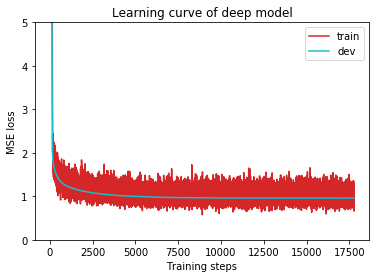

In [15]:
plot_learning_curve(model_loss_record, title='deep model')

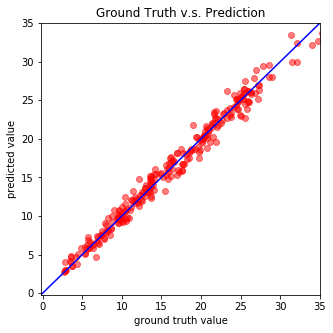

In [16]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [17]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
